In [25]:
!pip install pandas numpy matplotlib seaborn scikit-learn wordcloud
!pip install TikTokApi


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from wordcloud import WordCloud

# Thiết lập hiển thị
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

In [4]:
from google.colab import files
uploaded = files.upload()

Saving tiktok_processed.csv to tiktok_processed.csv


In [10]:
df = pd.read_csv('tiktok_processed.csv')
print(df.info())
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   video_id        2000 non-null   object 
 1   user_id         2000 non-null   object 
 2   followers       2000 non-null   int64  
 3   duration        2000 non-null   int64  
 4   views           2000 non-null   int64  
 5   likes           2000 non-null   int64  
 6   comments        2000 non-null   int64  
 7   shares          2000 non-null   int64  
 8   hashtag         2000 non-null   object 
 9   upload_time     2000 non-null   object 
 10  engagement      2000 non-null   float64
 11  like_rate       2000 non-null   float64
 12  comment_rate    2000 non-null   float64
 13  share_rate      2000 non-null   float64
 14  upload_date     2000 non-null   object 
 15  upload_weekday  2000 non-null   object 
 16  cluster         2000 non-null   int64  
 17  is_viral        2000 non-null   i

,0
video_id,0
user_id,0
followers,0
duration,0
views,0
likes,0
comments,0
shares,0
hashtag,0
upload_time,0


In [11]:
# Thiết lập seed để kết quả lặp lại
np.random.seed(42)

n = 2000  # số video / bản ghi mô phỏng

# Tạo các trường dữ liệu
video_id = [f"vid_{i}" for i in range(n)]
user_id = [f"user_{np.random.randint(0,300)}" for _ in range(n)]
duration = np.random.exponential(scale=15, size=n).clip(3, 180).round().astype(int)  # giây
followers = np.random.randint(50, 500000, size=n)

# Tạo views dựa trên followers, duration, noise
base_views = (followers * np.random.uniform(0.001, 0.02, size=n)).astype(int)
engagement_factor = np.random.normal(1.0, 0.4, size=n).clip(0.2, 3.0)
views = (base_views * engagement_factor + np.random.randint(0, 1000, size=n)).astype(int).clip(0, None)

likes = (views * np.random.uniform(0.02, 0.2, size=n)).astype(int)
comments = (views * np.random.uniform(0.001, 0.02, size=n)).astype(int)
shares = (views * np.random.uniform(0.0005, 0.01, size=n)).astype(int)

# Hashtag: chọn ngẫu nhiên trong tập hashtag mô phỏng
hashtags_pool = [
    "funny", "music", "dance", "challenge", "food", "lifehack", "beauty", "fashion",
    "travel", "gaming", "pets", "education", "fitness", "art", "motivation"
]
hashtag = [np.random.choice(hashtags_pool, p=np.random.dirichlet(np.ones(len(hashtags_pool)))) for _ in range(n)]

# Thời gian đăng
upload_time = pd.to_datetime('2025-01-01') + pd.to_timedelta(np.random.randint(0, 365, size=n), unit='d')

df = pd.DataFrame({
    "video_id": video_id,
    "user_id": user_id,
    "followers": followers,
    "duration": duration,
    "views": views,
    "likes": likes,
    "comments": comments,
    "shares": shares,
    "hashtag": hashtag,
    "upload_time": upload_time
})

# Thêm cuộc kiểm soát: tránh giá trị 0 ở views
df['views'] = df['views'].replace(0, np.random.randint(1,50))
df.head()


,video_id,user_id,followers,duration,views,likes,comments,shares,hashtag,upload_time
0,vid_0,user_102,385996,15,2933,222,43,8,art,2025-08-13
1,vid_1,user_270,323770,4,861,168,10,2,funny,2025-06-16
2,vid_2,user_106,306113,4,3657,258,50,15,funny,2025-10-23
3,vid_3,user_71,213225,4,1605,307,12,10,lifehack,2025-06-21
4,vid_4,user_188,3408,3,204,6,1,0,beauty,2025-06-13


In [12]:
# Tiền xử lý & Feature engineering
# Tạo engagement_rate
df['engagement'] = (df['likes'] + df['comments'] + df['shares']) / df['views']

# Tạo feature mới: like_rate, comment_rate, share_rate
df['like_rate'] = df['likes'] / df['views']
df['comment_rate'] = df['comments'] / df['views']
df['share_rate'] = df['shares'] / df['views']

# Rút trích ngày đăng
df['upload_date'] = df['upload_time'].dt.date
df['upload_weekday'] = df['upload_time'].dt.day_name()

# Kiểm tra missing & basic stats
print(df.isna().sum())
df.describe().T


video_id          0
user_id           0
followers         0
duration          0
views             0
likes             0
comments          0
shares            0
hashtag           0
upload_time       0
engagement        0
like_rate         0
comment_rate      0
share_rate        0
upload_date       0
upload_weekday    0
dtype: int64


,count,mean,min,25%,50%,75%,max,std
followers,2000.0,251553.177,265.0,126728.25,255149.5,372011.5,499909.0,142982.763762
duration,2000.0,15.5765,3.0,5.0,11.0,21.0,122.0,14.695139
views,2000.0,3154.084,43.0,1166.0,2276.0,4387.25,16649.0,2713.222794
likes,2000.0,353.7915,4.0,100.0,224.0,454.0,2786.0,385.155
comments,2000.0,31.995,0.0,9.0,19.0,40.25,300.0,36.718062
shares,2000.0,16.098,0.0,4.0,10.0,21.0,141.0,18.219917
upload_time,2000,2025-07-03 17:59:16.799999744,2025-01-01 00:00:00,2025-04-01 00:00:00,2025-07-11 00:00:00,2025-10-04 00:00:00,2025-12-31 00:00:00,NaN
engagement,2000.0,0.125817,0.016393,0.080574,0.125942,0.172429,0.22683,0.052766
like_rate,2000.0,0.110894,0.016393,0.066055,0.110626,0.157143,0.1999,0.052239
comment_rate,2000.0,0.01002,0.0,0.005071,0.009921,0.014948,0.019941,0.00558


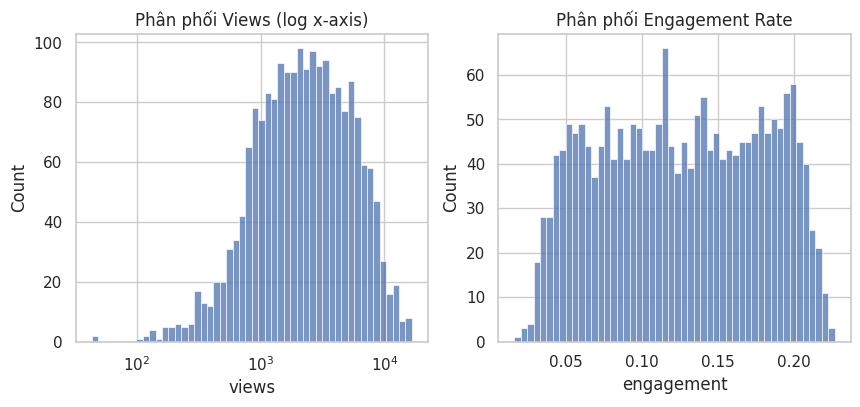

In [13]:
#Phân phối Views và Engagement(Tương tác)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(df['views'], bins=50, log_scale=(True, False))
plt.title('Phân phối Views (log x-axis)')

plt.subplot(1,2,2)
sns.histplot(df['engagement'], bins=50)
plt.title('Phân phối Engagement Rate')
plt.show()


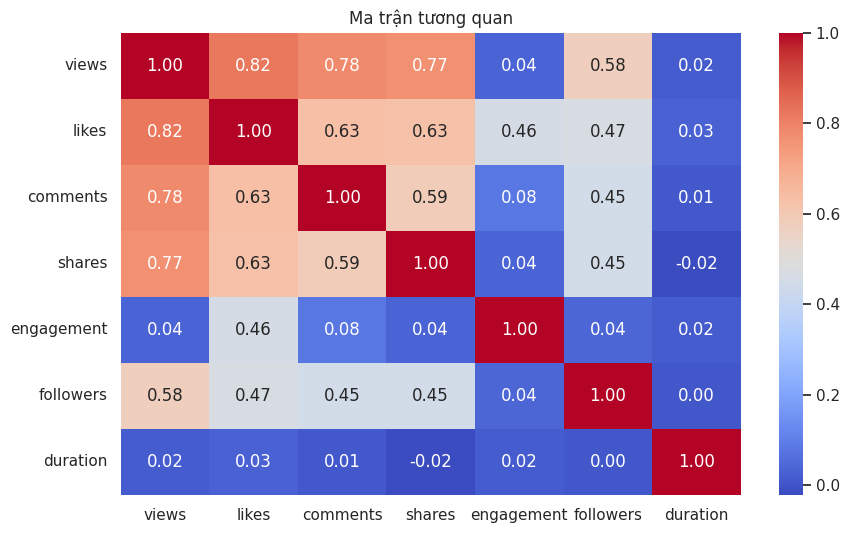

In [14]:
# Mối tương quan giữa các chỉ số
corr_cols = ['views','likes','comments','shares','engagement','followers','duration']
sns.heatmap(df[corr_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Ma trận tương quan")
plt.show()


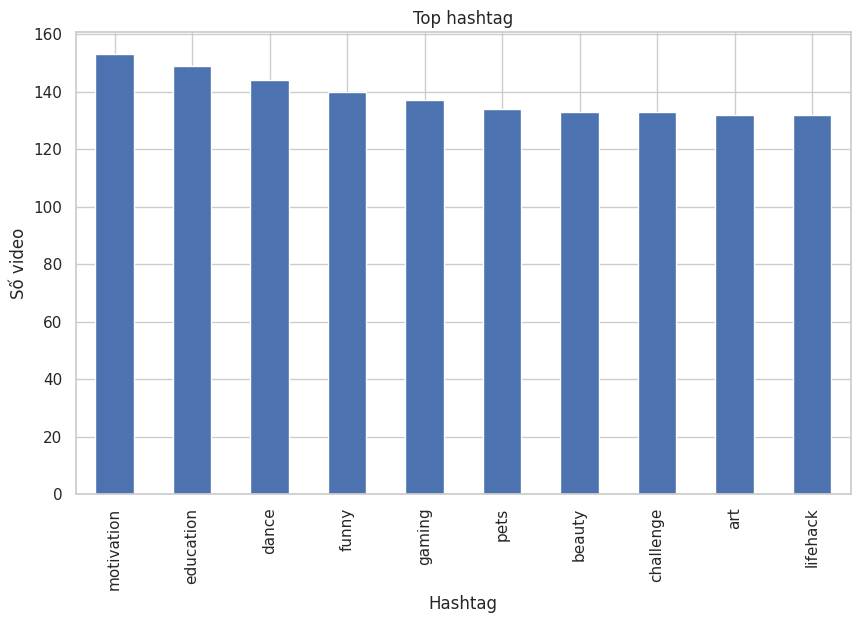

In [15]:
#4.3 Top Hashtag phổ biến
top_tags = df['hashtag'].value_counts().head(10)
top_tags.plot(kind='bar')
plt.title('Top hashtag')
plt.xlabel('Hashtag')
plt.ylabel('Số video')
plt.show()


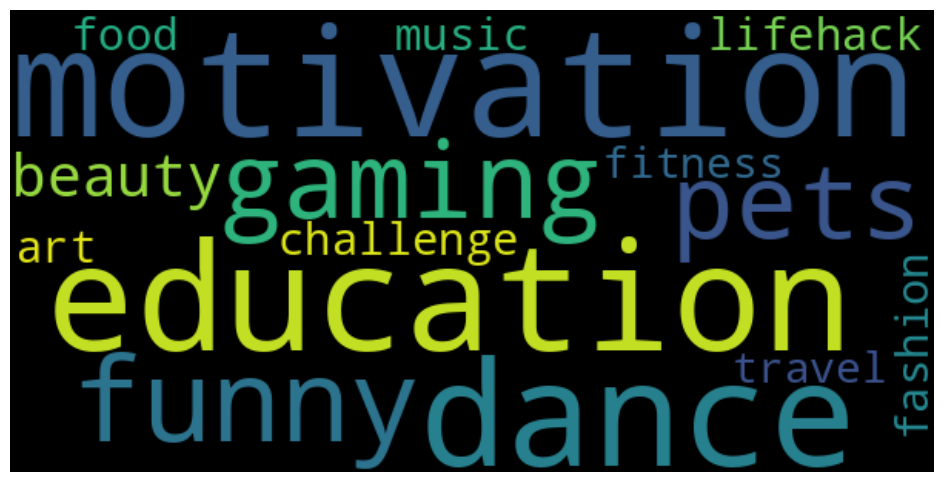

In [16]:
#WordCloud cho hashtag / caption(Mô Phỏng)
text = ' '.join(df['hashtag'])
wc = WordCloud(width=600, height=300, background_color='black').generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


In [17]:
#Phân cụm hành vi người dùng
X = df[['likes','comments','shares','views','followers','duration']].copy()
# Log transform để giảm độ lệch lớn
X_log = np.log1p(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

# Chọn k bằng Silhouette (thử k=2..6)
sil_scores = {}
for k in range(2,7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores[k] = sil

sil_scores


{2: np.float64(0.32549429138109676),
 3: np.float64(0.2233126908203596),
 4: np.float64(0.21727580802076443),
 5: np.float64(0.20225218610233361),
 6: np.float64(0.19833590979064172)}

In [18]:
# Chọn k tốt nhất
best_k = max(sil_scores, key=sil_scores.get)
best_k


2

In [19]:
# Fit KMeans với best_k
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Thống kê theo cluster
cluster_summary = df.groupby('cluster').agg({
    'views':'median',
    'likes':'median',
    'comments':'median',
    'shares':'median',
    'followers':'median',
    'engagement':'median',
    'video_id':'count'
}).rename(columns={'video_id':'count'}).sort_values('views', ascending=False)
cluster_summary


,views,likes,comments,shares,followers,engagement,count
cluster,,,,,,,
1,3991.0,408.0,36.0,19.0,335027.0,0.134415,1125
0,1065.0,94.0,9.0,4.0,122069.0,0.116137,875


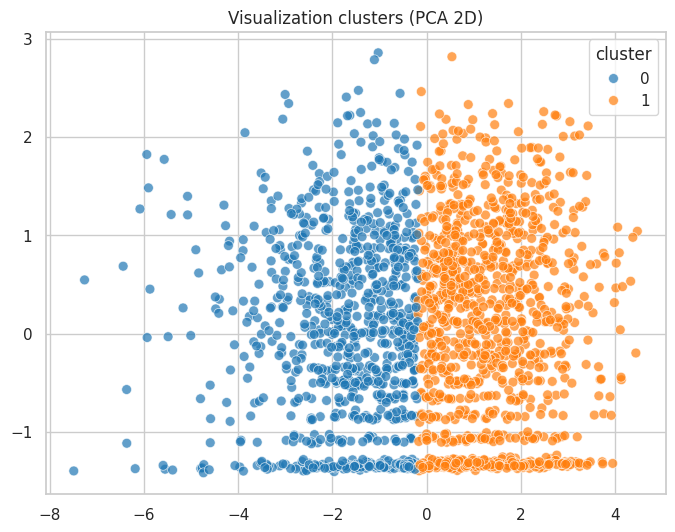

In [20]:
#(Mô phỏng 2D bằng PCA để dễ nhìn)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=pc[:,0], y=pc[:,1], hue=df['cluster'], palette='tab10', s=50, alpha=0.7)
plt.title('Visualization clusters (PCA 2D)')
plt.legend(title='cluster')
plt.show()


🎯 KẾT QUẢ MÔ HÌNH RANDOM FOREST
RMSE: 826.53
R²: 0.8904


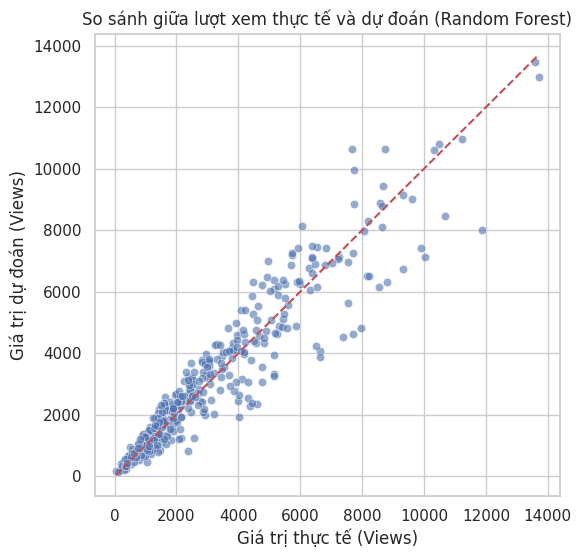

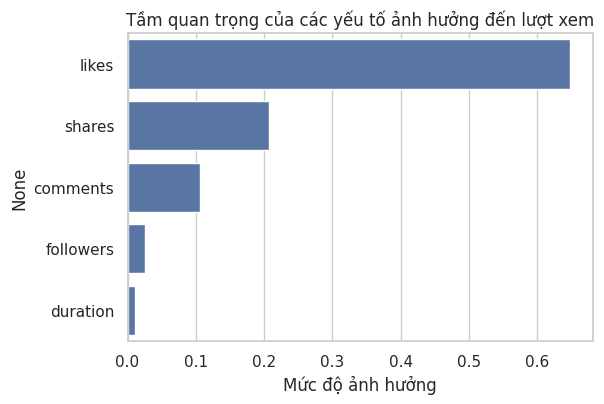

In [21]:
#(Dự đoán lượt xem [Linear Regression])
# Chọn features & target
features = ['likes','comments','shares','followers','duration']
X = df[features]
y = df['views']

# ====== 1️⃣ CHỌN FEATURES & TARGET ======
features = ['likes', 'comments', 'shares', 'followers', 'duration']
X = df[features]
y = df['views']

# ====== 2️⃣ LOG TRANSFORM (TÙY CHỌN — giúp ổn định dữ liệu) ======
X_log = np.log1p(X)
y_log = np.log1p(y)

# ====== 3️⃣ CHIA TRAIN/TEST ======
X_train, X_test, y_train, y_test = train_test_split(
    X_log, y_log, test_size=0.2, random_state=42
)

# ====== 4️⃣ KHỞI TẠO VÀ HUẤN LUYỆN MÔ HÌNH ======
model = RandomForestRegressor(
    n_estimators=200,     # số cây
    max_depth=10,         # độ sâu tối đa mỗi cây
    random_state=42,
    n_jobs=-1             # chạy đa luồng cho nhanh
)
model.fit(X_train, y_train)

# ====== 5️⃣ DỰ ĐOÁN ======
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

# ====== 6️⃣ ĐÁNH GIÁ ======
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("🎯 KẾT QUẢ MÔ HÌNH RANDOM FOREST")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# ====== 7️⃣ VẼ BIỂU ĐỒ SO SÁNH ======
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
plt.xlabel("Giá trị thực tế (Views)")
plt.ylabel("Giá trị dự đoán (Views)")
plt.title("So sánh giữa lượt xem thực tế và dự đoán (Random Forest)")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.show()

# ====== 8️⃣ TẦM QUAN TRỌNG CỦA BIẾN (Feature Importance) ======
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Tầm quan trọng của các yếu tố ảnh hưởng đến lượt xem")
plt.xlabel("Mức độ ảnh hưởng")
plt.show()


📌 LINEAR REGRESSION
RMSE: 1180.71
R²: 0.7763

📌 RANDOM FOREST
RMSE: 826.53
R²: 0.8904


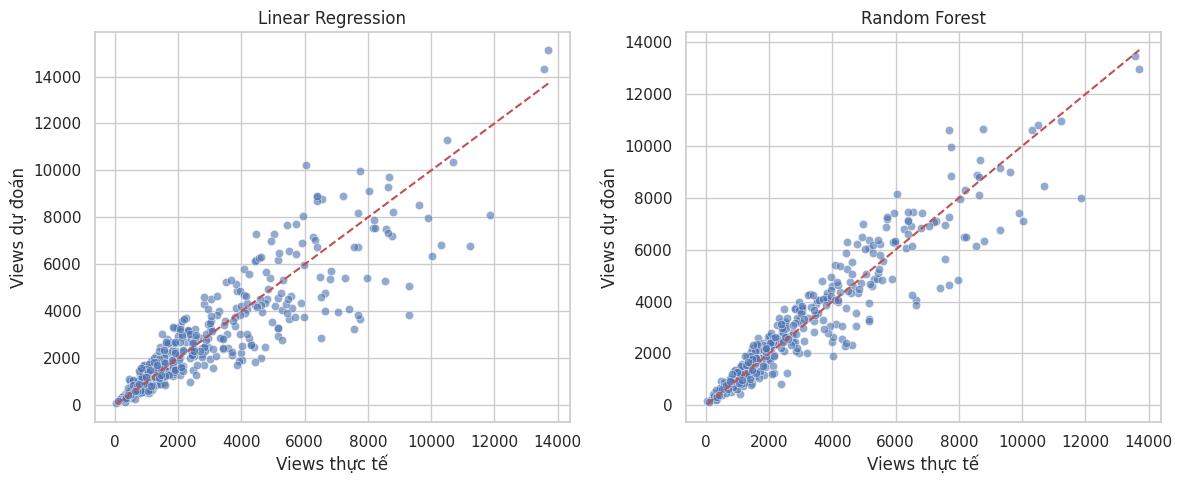

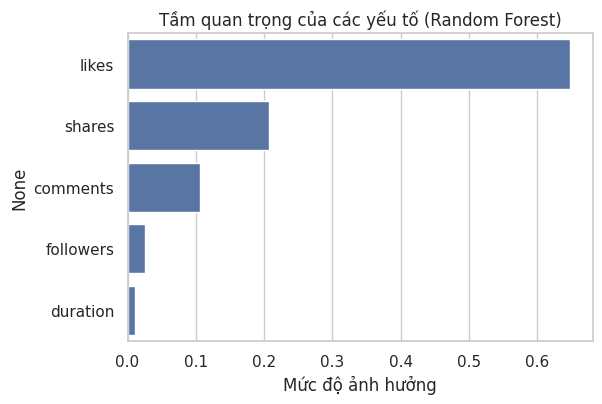

In [22]:
# ============================================
# 🔹 SO SÁNH MÔ HÌNH LINEAR REGRESSION VS RANDOM FOREST
# ============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ====== 1️⃣ CHỌN FEATURES & TARGET ======
features = ['likes','comments','shares','followers','duration']
X = df[features]
y = df['views']

# ====== 2️⃣ LOG TRANSFORM ======
X_log = np.log1p(X)
y_log = np.log1p(y)

# ====== 3️⃣ CHIA TRAIN/TEST ======
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

# ====== 4️⃣ MÔ HÌNH LINEAR REGRESSION ======
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = np.expm1(lr_model.predict(X_test))
y_true = np.expm1(y_test)

rmse_lr = np.sqrt(mean_squared_error(y_true, y_pred_lr))
r2_lr = r2_score(y_true, y_pred_lr)

print("📌 LINEAR REGRESSION")
print(f"RMSE: {rmse_lr:.2f}")
print(f"R²: {r2_lr:.4f}")

# ====== 5️⃣ MÔ HÌNH RANDOM FOREST ======
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = np.expm1(rf_model.predict(X_test))

rmse_rf = np.sqrt(mean_squared_error(y_true, y_pred_rf))
r2_rf = r2_score(y_true, y_pred_rf)

print("\n📌 RANDOM FOREST")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R²: {r2_rf:.4f}")

# ====== 6️⃣ SO SÁNH TRỰC QUAN ======
plt.figure(figsize=(12,5))

# Linear Regression
plt.subplot(1,2,1)
sns.scatterplot(x=y_true, y=y_pred_lr, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Views thực tế")
plt.ylabel("Views dự đoán")
plt.title("Linear Regression")

# Random Forest
plt.subplot(1,2,2)
sns.scatterplot(x=y_true, y=y_pred_rf, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Views thực tế")
plt.ylabel("Views dự đoán")
plt.title("Random Forest")

plt.tight_layout()
plt.show()

# ====== 7️⃣ Feature Importance của Random Forest ======
importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Tầm quan trọng của các yếu tố (Random Forest)")
plt.xlabel("Mức độ ảnh hưởng")
plt.show()


In [23]:
# Dự đoán viral
threshold = df['views'].quantile(0.95)
df['is_viral'] = (df['views'] >= threshold).astype(int)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X = df[features]
y = df['is_viral']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       380
           1       0.89      0.80      0.84        20

    accuracy                           0.98       400
   macro avg       0.94      0.90      0.92       400
weighted avg       0.98      0.98      0.98       400



In [ ]:
from google.colab import files
files.download('tiktok_processed.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>